In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vincenty import vincenty # geopy.distance can also be used

from ipyleaflet import Map,basemaps, basemap_to_tiles
from ipyleaflet import LayersControl,FullScreenControl,ScaleControl
from ipyleaflet import CircleMarker,AntPath,Marker
import datetime

# 1.Chargement des données

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [3]:
df_mess_train.head(2)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721


In [4]:
df_mess_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39250 entries, 0 to 39249
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   messid   39250 non-null  object 
 1   bsid     39250 non-null  int64  
 2   did      39250 non-null  float64
 3   nseq     39250 non-null  float64
 4   rssi     39250 non-null  float64
 5   time_ux  39250 non-null  float64
 6   bs_lat   39250 non-null  float64
 7   bs_lng   39250 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [36]:
pos_train.head(2)

,lat,lng
0,39.60669,-104.95849
1,39.60669,-104.95849


In [37]:
pos_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39250 entries, 0 to 39249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     39250 non-null  float64
 1   lng     39250 non-null  float64
dtypes: float64(2)
memory usage: 613.4 KB


In [7]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


Remarque : On a un jeu contenant 39250 enregistrement **avec absence de non valeurs**. Pour ce qui concerne les features : bsid, did sont des entiers identifiants, nseq variable catégorielle, rssi variable continue, time_ux tempsu UNIX

# 2. Analyse des données d'entrées 

On commence par créer un DF qui va concaténer les informations X et réels positionnements Y

In [71]:
df=pd.concat([df_mess_train, pos_train], axis = 1)
df["time"]=df['time_ux'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000))
df["err"]=np.sqrt((df["bs_lat"]-df["lat"])**2 + (df["bs_lng"]-df["lng"])**2)*80
df.head(2)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,time,err
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.60669,-104.95849,2016-05-18 06:38:49,0.933191
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.60669,-104.95849,2016-05-18 06:38:49,5.663759


A quoi correspondent tous ces enregistrements ?

In [38]:
print (f"On a dans le jeu train {(df.messid.nunique())} messages provenant de {(df.did.nunique())} objets avec un réseau de {(df.bsid.nunique())} bases")

On a dans le jeu train 6068 messages provenant de 113 objets avec un réseau de 251 bases


On se propose maintenant de cartographier ce réseau d'enregistrement i.e. les bases vs objet

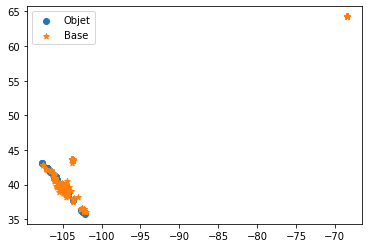

In [57]:
plt.scatter(df.lng,df.lat)
plt.scatter(df.bs_lng,df.bs_lat,marker="*")
plt.legend(["Objet","Base"]);

On voit qu'on a des bases très éloignées du réseau à des latitudes polaires (lat>60) qui devraient créer des anomalies, cartographions ces bases.

In [65]:
def carte_station(df,z=1): 

    df = df.groupby('bsid').mean()
    center = (df.bs_lat.mean(),df.bs_lng.mean())
    m = Map(basemap=basemaps.Esri.WorldImagery,center=center, zoom=z)

    for i in range (df.shape[0]):
        name=df.iloc[i].name
        position = (df.iloc[i].bs_lat,df.iloc[i].bs_lng)
        marker1 = Marker(location=position, draggable=False,name=str(name))
        m.add_layer(marker1);

    control = LayersControl(position='topright')
    m.add_control(control)
    print (f'On a {i+1} stations différentes dans la sélection')
    return m

In [66]:
carte_station(df_mess_train[df_mess_train["bs_lat"]>60],5)

On a 27 stations différentes dans la sélection


Map(center=[64.2999999999999, -68.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Il parait peut probable d'avoir des antennes sigfox dans ce milieu. Pour observer des anomalies dans le jeu de données, on propose de regarder la distribution des distances entre base enregistrant un message et l'objet émettant le signal et son expression sur les messures RSSI.

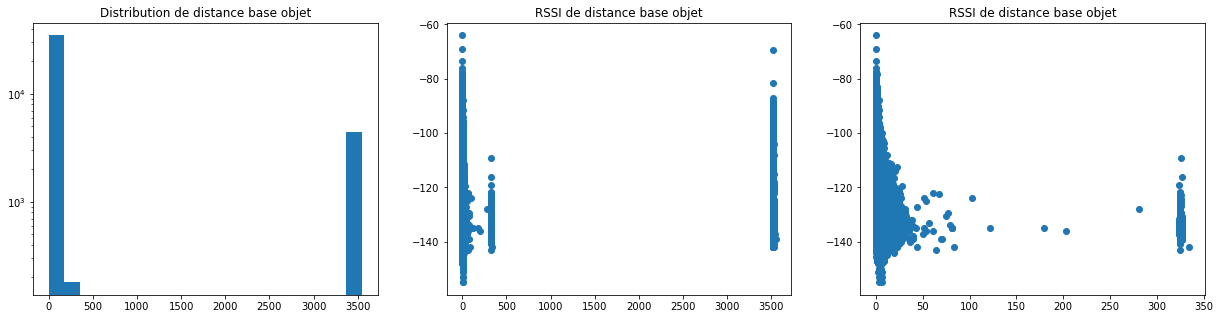

In [86]:
plt.figure(1,figsize=[21,5])
plt.subplot(1,3,1)
plt.title("Distribution de distance base objet")
plt.hist(df["err"],bins=20,log=True)
plt.subplot(1,3,2)
plt.title("RSSI de distance base objet")
plt.scatter(df["err"],df["rssi"]);
plt.subplot(1,3,3)
plt.title("RSSI de distance base objet")
plt.scatter(df[df["bs_lat"]<60]["err"],df[df["bs_lat"]<60]["rssi"]);

* Figure gauche : Sur l'histograme à gauche on voit bien qu'on a 3 groupes de distances émmeteur/recepteur. Le groupe le plus extrême correspond aux balises localisées dans le Grand Nord.

* Figure milieu : On voit que ces enregistrements à distance extrême (plus de 3000km) ne montre pas d'atténuation cohérente avec cette distance.

* Figure droite : En désélectionnant tous les energistrements avec des balises à latitude > 60, on exclut ces distances extrêmes et atténuation incohérente.

On en conclu qu'il doit y avoir une erreur de saisies dans les coordonnées de ces balises et quelles sont donc inexploitable. On va donc les retirer du jeu de donnée. Regardons maintenant si on peut avoir aussi des indications sur la deuxième partie anomalique.

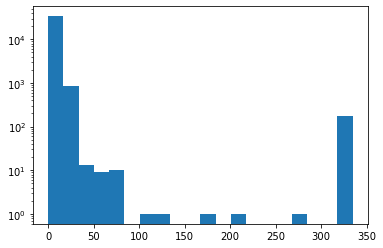

In [100]:
plt.hist(df[df["err"]<3000]["err"],bins=20,log=True);

In [99]:
df[(df["err"]<3000)&(df["err"]>300)].describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,177.000000,177.0,177.000000,177.000000,1.770000e+02,177.000000,177.000000,1.770000e+02,1.770000e+02,177.000000
mean,3274.870056,473288.0,1.028249,-133.457627,1.479274e+12,43.638815,-103.758493,3.977454e+01,-1.050393e+02,325.694759
std,518.859315,0.0,0.597622,4.907084,1.748624e+07,0.024232,0.032441,1.353861e-13,3.705304e-13,1.311354
min,1443.000000,473288.0,0.000000,-143.000000,1.479243e+12,43.599230,-103.815822,3.977454e+01,-1.050393e+02,323.867031
25%,2803.000000,473288.0,0.500000,-137.000000,1.479259e+12,43.614138,-103.765896,3.977454e+01,-1.050393e+02,324.706099
50%,2808.000000,473288.0,1.000000,-135.000000,1.479275e+12,43.639226,-103.761023,3.977454e+01,-1.050393e+02,325.648967
75%,3848.000000,473288.0,1.500000,-131.000000,1.479288e+12,43.657480,-103.723449,3.977454e+01,-1.050393e+02,326.763488
max,4013.000000,473288.0,2.000000,-109.000000,1.479302e+12,43.725754,-103.671045,3.977454e+01,-1.050393e+02,334.513948


Encore une fois que ces distances correspondent à un groupe de base géolocalisé dans un meme endroit et éloigné du réseau. Etonnamment, elles ne sont connecté à un seul objet 473288.

In [129]:
carte_station(df[(df["err"]<3000)&(df["err"]>300)],5)

On a 9 stations différentes dans la sélection


Map(center=[43.64970571785556, -103.74913141944444], controls=(ZoomControl(options=['position', 'zoom_in_text'…

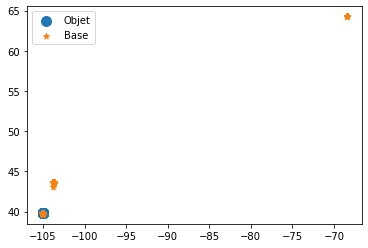

In [126]:
# Position objet 473288 et bases le détecant
plt.scatter(df[df["did"]==473288].lng,df[df["did"]==473288].lat,s = 100)
plt.scatter(df[df["did"]==473288].bs_lng,df[df["did"]==473288].bs_lat,marker="*")
plt.legend(["Objet","Base"]);

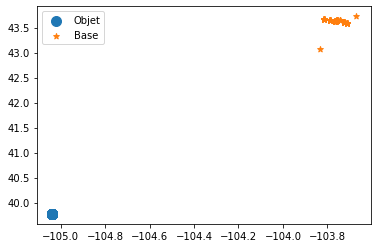

In [131]:
# Objets détectés par groupe base suspecte 2
plt.scatter(df[(df["bs_lat"]>43)&(df["bs_lat"]<60)].lng,df[(df["bs_lat"]>43)&(df["bs_lat"]<60)].lat,s = 100)
plt.scatter(df[(df["bs_lat"]>43)&(df["bs_lat"]<60)].bs_lng,df[(df["bs_lat"]>43)&(df["bs_lat"]<60)].bs_lat,marker="*")
plt.legend(["Objet","Base"]);

In [135]:
df[(df["bs_lat"]>43)&(df["bs_lat"]<60)]['did'].nunique()

1

In [140]:
df_clean=df[df["err"]<300]

In [141]:
def nbr_message(df1,df2):
    return df1['messid'].nunique()-df2['messid'].nunique()

In [147]:
print(f"On a supprimé l'accès à {nbr_message(df,df_clean)} messages sans possiblité de géolocalisation")

On a supprimé l'accès à 197 messages sans possiblité de géolocalisation


# Brouillon A jeter

In [11]:
toto=pos_train.groupby('lat').mean()
print(pos_train.nunique(),toto.nunique())
print(f"On a bien dans le dataset {toto.nunique()[0]} position GPS enregistré différentes")

lat    6004
lng    6004
dtype: int64 lng    6004
dtype: int64
On a bien dans le dataset 6004 position GPS enregistré différentes


In [171]:
def carte_objet(df,z=1): # t = station ou objet ?

    df = df.groupby('messid').mean()
    center = (df.lat.mean(),df.lng.mean())
    m = Map(basemap=basemaps.Esri.WorldImagery,center=center, zoom=z)

    for i in range (df.shape[0]):
        name=df.iloc[i].name
        position = (df.iloc[i].lat,df.iloc[i].lng)
        marker1 = Marker(location=position, draggable=False,name=str(name))
        m.add_layer(marker1);

    control = LayersControl(position='topright')
    m.add_control(control)
    print (f'On a {i+1} stations différentes dans le jeu de données carté')
    return m

In [ ]:
carte_objet(df)

In [167]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [9]:
len(listOfBs)

259

In [10]:
df_mess_train['messid'].value_counts()

57aeb41fe541cd77a044cdb8    106
583c50decf554f7e3a360e58     81
582c96ffcf554f7e3ab32732     80
582c996c12f1434b9c20a854     80
582c922212f1434b9c1aec97     77
                           ... 
583b2e51e541cd03e703933e      1
577b3b7312f1433182fdff35      1
5840232fcf554f7e3a3cec17      1
581b712fcf554f508cb71d1e      1
580f2141e541cd2ed54ae3ac      1
Name: messid, Length: 6068, dtype: int64

In [11]:
df_mess_train[df_mess_train['messid']=='57aeb41fe541cd77a044cdb8']

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
14238,57aeb41fe541cd77a044cdb8,980,476609.0,1.0,-122.333333,1.471067e+12,38.997730,-104.684275
14239,57aeb41fe541cd77a044cdb8,1156,476609.0,0.0,-136.000000,1.471067e+12,38.170898,-103.046812
14240,57aeb41fe541cd77a044cdb8,1187,476609.0,1.0,-135.000000,1.471067e+12,37.963785,-103.690818
14241,57aeb41fe541cd77a044cdb8,1226,476609.0,0.0,-134.000000,1.471067e+12,39.620670,-105.371089
14242,57aeb41fe541cd77a044cdb8,1237,476609.0,1.0,-136.000000,1.471067e+12,39.553245,-105.220746
...,...,...,...,...,...,...,...,...
14339,57aeb41fe541cd77a044cdb8,10148,476609.0,1.0,-135.000000,1.471067e+12,38.405794,-104.362678
14340,57aeb41fe541cd77a044cdb8,10151,476609.0,0.5,-121.500000,1.471067e+12,64.300000,-68.500000
14341,57aeb41fe541cd77a044cdb8,10162,476609.0,1.0,-112.000000,1.471067e+12,64.300000,-68.500000
14342,57aeb41fe541cd77a044cdb8,10999,476609.0,1.0,-137.000000,1.471067e+12,64.300000,-68.500000


In [12]:
pos_train.shape

(39250, 2)

In [13]:
df_mess_train.columns

Index(['messid', 'bsid', 'did', 'nseq', 'rssi', 'time_ux', 'bs_lat', 'bs_lng'], dtype='object')

In [14]:
df_base=df_mess_train.drop(columns=['messid', 'did','nseq','rssi', 'time_ux'])
df_base=df_base.groupby('bsid').mean()
df_base

,bs_lat,bs_lng
bsid,,
879,39.739013,-105.392793
911,42.324279,-107.159505
921,42.131222,-107.008741
944,41.424900,-106.143919
980,38.997730,-104.684275
...,...,...
10151,64.300000,-68.500000
10162,64.300000,-68.500000
10999,64.300000,-68.500000


In [19]:
center = (df_base.iloc[0].bs_lat,df_base.iloc[0].bs_lng)
m = Map(center=center, zoom=2)


for i in range (df_base.shape[0]):
    name=df_base.iloc[i].name
    position = (df_base.iloc[i].bs_lat,df_base.iloc[i].bs_lng)
    marker = Marker(location=position, draggable=False,name=str(name))
    m.add_layer(marker);

control = LayersControl(position='topright')
m.add_control(control)
m

Map(center=[39.739013090300006, -105.392793341], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

In [20]:
import datetime

df_mess_train["time"]=df_mess_train['time_ux'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000))
df_mess_train

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,time
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,2016-05-18 06:38:49
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,2016-05-18 06:38:49
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,2016-05-18 06:45:07
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,2016-05-18 08:33:52
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,2016-05-18 08:33:52
...,...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424,2016-12-07 20:46:54
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753,2016-12-07 20:46:54
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415,2016-12-07 20:46:54
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832,2016-12-07 21:43:31


In [41]:
df["err"]=np.sqrt((df["bs_lat"]-df["lat"])**2 + (df["bs_lng"]-df["lng"])**2)*80
df

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,time,lat,lng,err
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,2016-05-18 06:38:49,39.606690,-104.958490,0.933191
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,2016-05-18 06:38:49,39.606690,-104.958490,5.663759
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,2016-05-18 06:45:07,39.637741,-104.958554,4.491520
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,2016-05-18 08:33:52,39.730417,-104.968940,9.955954
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,2016-05-18 08:33:52,39.730417,-104.968940,1.172267
...,...,...,...,...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424,2016-12-07 20:46:54,39.773264,-105.014052,0.995344
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753,2016-12-07 20:46:54,39.773264,-105.014052,1.319823
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415,2016-12-07 20:46:54,39.773264,-105.014052,1.501024
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832,2016-12-07 21:43:31,39.908186,-105.168297,1.376335


In [42]:
#tri selon objet et temps
df=df.sort_values(by = ['did', 'time_ux'])
df.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343,399.177471
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954,1107.794549
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.019176
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463,1.842180
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440,3.860696
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730,8.008775
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289,3548.090173


In [43]:
# les grandes erreurs proviennent des stations dans el Grand Nord !
df[df["err"]>3000].describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,4389.000000,4.389000e+03,4389.000000,4389.000000,4.389000e+03,4.389000e+03,4389.0,4389.000000,4389.000000,4389.000000
mean,6144.622465,4.986286e+05,1.038847,-125.300828,1.476081e+12,6.430000e+01,-68.5,39.759422,-105.029877,3520.617450
std,3451.227827,1.690960e+05,0.601033,9.230369,4.015779e+09,5.272828e-12,0.0,0.072178,0.051676,1.864357
min,1092.000000,4.732880e+05,0.000000,-142.000000,1.466007e+12,6.430000e+01,-68.5,39.537137,-107.066221,3515.992961
25%,2707.000000,4.741810e+05,1.000000,-132.000000,1.472799e+12,6.430000e+01,-68.5,39.707218,-105.047845,3519.231022
50%,4993.000000,4.763150e+05,1.000000,-127.000000,1.477406e+12,6.430000e+01,-68.5,39.773364,-105.028769,3520.563387
75%,10151.000000,4.768290e+05,1.500000,-120.500000,1.479316e+12,6.430000e+01,-68.5,39.792541,-105.018591,3522.154543
max,11951.000000,1.747448e+06,2.000000,-69.333333,1.481140e+12,6.430000e+01,-68.5,42.452279,-104.921795,3548.090173


In [44]:
# onvérifie si elle apporte qqhcose
df[df["bs_lat"]>60].describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,4389.000000,4.389000e+03,4389.000000,4389.000000,4.389000e+03,4.389000e+03,4389.0,4389.000000,4389.000000,4389.000000
mean,6144.622465,4.986286e+05,1.038847,-125.300828,1.476081e+12,6.430000e+01,-68.5,39.759422,-105.029877,3520.617450
std,3451.227827,1.690960e+05,0.601033,9.230369,4.015779e+09,5.272828e-12,0.0,0.072178,0.051676,1.864357
min,1092.000000,4.732880e+05,0.000000,-142.000000,1.466007e+12,6.430000e+01,-68.5,39.537137,-107.066221,3515.992961
25%,2707.000000,4.741810e+05,1.000000,-132.000000,1.472799e+12,6.430000e+01,-68.5,39.707218,-105.047845,3519.231022
50%,4993.000000,4.763150e+05,1.000000,-127.000000,1.477406e+12,6.430000e+01,-68.5,39.773364,-105.028769,3520.563387
75%,10151.000000,4.768290e+05,1.500000,-120.500000,1.479316e+12,6.430000e+01,-68.5,39.792541,-105.018591,3522.154543
max,11951.000000,1.747448e+06,2.000000,-69.333333,1.481140e+12,6.430000e+01,-68.5,42.452279,-104.921795,3548.090173


In [45]:
df_ajeter=df[df["bs_lat"]>60]
df_ajeter=df_ajeter.groupby('bsid').mean().reset_index()
df_ajeter

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
0,1092,476829.000000,0.984375,-140.489583,1.479829e+12,64.3,-68.5,39.706370,-105.018983,3522.256315
1,1594,488918.027586,1.070690,-129.626437,1.474736e+12,64.3,-68.5,39.768731,-105.031720,3520.318869
2,1661,475540.206250,1.003125,-129.806250,1.477277e+12,64.3,-68.5,39.726251,-104.996863,3519.900784
3,1743,543442.242604,1.026627,-118.848126,1.478466e+12,64.3,-68.5,39.774106,-105.039359,3520.586758
4,1772,528765.471074,0.966942,-131.979339,1.479186e+12,64.3,-68.5,39.778844,-105.035314,3520.108244
5,1796,536390.522088,0.949799,-127.886881,1.478437e+12,64.3,-68.5,39.755985,-105.060557,3522.804249
6,1854,476368.962963,1.129630,-131.722222,1.480451e+12,64.3,-68.5,39.693439,-105.011986,3522.370346
7,2293,476905.000000,0.000000,-142.000000,1.474857e+12,64.3,-68.5,39.826703,-105.140654,3524.988884
8,2707,475451.089005,1.041885,-117.216405,1.478903e+12,64.3,-68.5,39.721958,-105.018460,3521.526127
9,2943,476564.655556,1.111111,-121.072222,1.479479e+12,64.3,-68.5,39.721692,-105.018281,3521.525604


In [27]:
center = (df_ajeter.iloc[0].bs_lat,df_ajeter.iloc[0].bs_lng)
m = Map(center=center, zoom=5)

for i in range (df_ajeter.shape[0]):
    name=df_ajeter.iloc[i].bsid
    position = (df_ajeter.iloc[i].bs_lat,df_ajeter.iloc[i].bs_lng)
    marker = Marker(location=position, draggable=False,name=str(name))
    m.add_layer(marker);

control = LayersControl(position='topright')
m.add_control(control)
m

Map(center=[64.29999999999997, -68.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…

In [47]:
df_clean1=df[df["bs_lat"]<60]
df_clean1.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,34861.000000,3.486100e+04,34861.000000,34861.000000,3.486100e+04,34861.000000,34861.000000,34861.000000,34861.000000,34861.000000
mean,4330.969020,4.817002e+05,1.044132,-125.934430,1.473027e+12,39.817302,-105.057619,39.786343,-105.059675,6.188169
std,2360.556415,8.595609e+04,0.558647,9.223712,5.574179e+09,0.349878,0.201467,0.217172,0.171645,23.358385
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.019176
25%,2790.000000,4.761400e+05,1.000000,-132.500000,1.467927e+12,39.744848,-105.077530,39.708777,-105.063488,1.673053
50%,3554.000000,4.763150e+05,1.000000,-127.500000,1.472834e+12,39.781464,-105.050984,39.777484,-105.041622,3.274951
75%,4790.000000,4.766060e+05,1.500000,-121.000000,1.478775e+12,39.816224,-105.010048,39.806971,-105.018756,6.118136
max,10148.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,43.725754,-102.011461,43.140387,-102.094289,334.513948


In [48]:
df.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343,399.177471
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954,1107.794549
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.019176
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463,1.842180
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440,3.860696
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730,8.008775
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289,3548.090173


In [50]:
df_clean1=df_clean1.sort_values(by = ['err'])

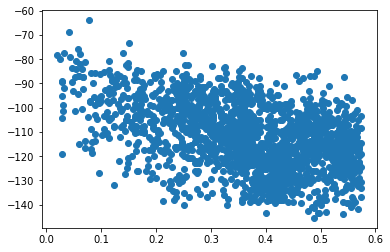

In [51]:
plt.scatter(df_clean1.err[0:2000],df_clean1.rssi[0:2000]);

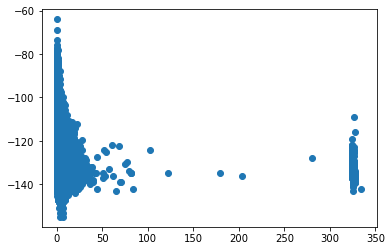

In [52]:
plt.scatter(df_clean1.err,df_clean1.rssi);

quand rssi < -110 plus de corrélation avec distance

In [56]:
df_clean1[df_clean1["err"]>300].describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
count,177.000000,177.0,177.000000,177.000000,1.770000e+02,177.000000,177.000000,1.770000e+02,1.770000e+02,177.000000
mean,3274.870056,473288.0,1.028249,-133.457627,1.479274e+12,43.638815,-103.758493,3.977454e+01,-1.050393e+02,325.694759
std,518.859315,0.0,0.597622,4.907084,1.748624e+07,0.024232,0.032441,1.353861e-13,3.705304e-13,1.311354
min,1443.000000,473288.0,0.000000,-143.000000,1.479243e+12,43.599230,-103.815822,3.977454e+01,-1.050393e+02,323.867031
25%,2803.000000,473288.0,0.500000,-137.000000,1.479259e+12,43.614138,-103.765896,3.977454e+01,-1.050393e+02,324.706099
50%,2808.000000,473288.0,1.000000,-135.000000,1.479275e+12,43.639226,-103.761023,3.977454e+01,-1.050393e+02,325.648967
75%,3848.000000,473288.0,1.500000,-131.000000,1.479288e+12,43.657480,-103.723449,3.977454e+01,-1.050393e+02,326.763488
max,4013.000000,473288.0,2.000000,-109.000000,1.479302e+12,43.725754,-103.671045,3.977454e+01,-1.050393e+02,334.513948


In [59]:
df_ajeter2=df_clean1[df_clean1["bs_lat"]>43]
df_ajeter2=df_ajeter2.groupby('bsid').mean().reset_index()
df_ajeter2        

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err
0,1443,473288.0,2.000000,-142.000000,1.479277e+12,43.725754,-103.671045,39.774541,-105.039339,334.513948
1,2800,473288.0,1.014286,-137.442857,1.479275e+12,43.631515,-103.765896,39.774541,-105.039339,324.940897
2,2803,473288.0,0.937500,-135.463542,1.479265e+12,43.657077,-103.756890,39.774541,-105.039339,327.108642
3,2808,473288.0,1.022727,-134.204545,1.479282e+12,43.599230,-103.712388,39.774541,-105.039339,323.867031
4,3501,473288.0,1.150000,-136.300000,1.479271e+12,43.639226,-103.761023,39.774541,-105.039339,325.648967
5,3630,473288.0,0.978261,-129.079710,1.479283e+12,43.657480,-103.790401,39.774541,-105.039339,326.308378
6,3848,473288.0,0.965517,-127.959770,1.479270e+12,43.614138,-103.723449,39.774541,-105.039339,324.706099
7,3933,473288.0,1.166667,-133.214286,1.479268e+12,43.671528,-103.815822,39.774541,-105.039339,326.763488
8,4013,473288.0,1.375000,-135.500000,1.479288e+12,43.651403,-103.745268,39.774541,-105.039339,326.970814
9,7508,473288.0,1.000000,-128.000000,1.479240e+12,43.065924,-103.831941,39.774541,-105.039339,280.468302


In [60]:
center = (df_ajeter2.iloc[0].bs_lat,df_ajeter2.iloc[0].bs_lng)
m = Map(basemap=basemaps.Esri.WorldImagery,center=center, zoom=5)

for i in range (df_ajeter2.shape[0]):
    name=df_ajeter2.iloc[i].bsid
    position = (df_ajeter2.iloc[i].bs_lat,df_ajeter2.iloc[i].bs_lng)
    marker = Marker(location=position, draggable=False,name=str(name))
    m.add_layer(marker);

control = LayersControl(position='topright')
m.add_control(control)
m

Map(center=[43.7257540271, -103.671045026], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

In [62]:
df_clean2=df_clean1[df_clean1["err"]<300]

In [63]:
df_clean2=df_clean2.sort_values(by = ["did","time_ux"]).reset_index()
df_clean2

,index,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,time,lat,lng,err
0,29806,582ae03712f1434b9cc93a71,2731,473288.0,1.5,-104.5,1.479205e+12,39.781464,-105.040763,2016-11-15 11:15:19,39.775428,-105.039537,0.492743
1,29810,582ae03712f1434b9cc93a71,8352,473288.0,0.0,-120.0,1.479205e+12,39.761633,-105.025753,2016-11-15 11:15:19,39.775428,-105.039537,1.560104
2,29807,582ae03712f1434b9cc93a71,3579,473288.0,2.0,-118.0,1.479205e+12,39.755019,-105.043315,2016-11-15 11:15:19,39.775428,-105.039537,1.660408
3,29808,582ae03712f1434b9cc93a71,4058,473288.0,0.0,-124.0,1.479205e+12,39.783211,-105.088747,2016-11-15 11:15:19,39.775428,-105.039537,3.985673
4,29816,582ae1d712f1434b9ccad421,2731,473288.0,1.0,-101.0,1.479205e+12,39.781464,-105.040763,2016-11-15 11:22:15,39.774984,-105.039440,0.529129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34679,23482,57f7a5aecf554f7f69755406,3545,1747448.0,0.0,-127.0,1.475848e+12,39.871902,-105.058842,2016-10-07 15:39:58,39.806297,-105.043233,5.394941
34680,23485,57f7a5aecf554f7f69755406,3565,1747448.0,2.0,-134.0,1.475848e+12,39.904082,-105.077825,2016-10-07 15:39:58,39.806297,-105.043233,8.297909
34681,23474,57f7a5aecf554f7f69755406,1859,1747448.0,2.0,-128.0,1.475848e+12,39.704887,-105.016392,2016-10-07 15:39:58,39.806297,-105.043233,8.392155
34682,23483,57f7a5aecf554f7f69755406,3554,1747448.0,0.0,-133.0,1.475848e+12,39.910758,-105.094684,2016-10-07 15:39:58,39.806297,-105.043233,9.315522


In [64]:
# on fait un gropu by par message avec moyenne des bases détectés
df_final=df_clean2.groupby(["messid"]).mean()
# on calcule nouvelle erreur versus moyenne base
df_final["err2"]=np.sqrt((df_final["bs_lat"]-df_final["lat"])**2 + (df_final["bs_lng"]-df_final["lng"])**2)*80
df_final.describe()

,index,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,err,err2
count,5871.000000,5871.000000,5.871000e+03,5871.000000,5871.000000,5.871000e+03,5871.000000,5871.000000,5871.000000,5871.000000,5871.000000,5871.000000
mean,18646.300613,4228.726466,4.823277e+05,1.042610,-125.109290,1.472954e+12,39.812583,-105.079401,39.805468,-105.075353,3.783294,2.809167
std,10672.970251,1491.825595,9.068119e+04,0.451270,7.016048,5.255985e+09,0.373525,0.298557,0.378751,0.293148,4.818717,4.775743
min,0.500000,980.000000,4.732880e+05,0.000000,-145.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.027689,0.015158
25%,9093.200000,3179.000000,4.761230e+05,0.857143,-129.333333,1.468058e+12,39.723151,-105.074910,39.706788,-105.067482,1.729221,0.878735
50%,19253.000000,4066.466667,4.763270e+05,1.000000,-126.166667,1.473229e+12,39.779908,-105.044848,39.776797,-105.043538,3.029451,1.802750
75%,26844.263158,4931.845588,4.765210e+05,1.250000,-122.300000,1.477484e+12,39.813488,-105.008827,39.817552,-104.996592,4.677195,3.551162
max,39248.500000,10148.000000,1.747448e+06,2.000000,-77.500000,1.481143e+12,43.065924,-102.011461,43.140387,-102.094289,280.468302,280.468302


In [72]:
df['messid'].nunique()

6068

In [69]:
df_clean1['messid'].nunique()

5918

In [70]:
df_clean2['messid'].nunique()

5871

In [71]:
df_clean['messid'].nunique()

5918